In [1]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns
import re
from transformers import BertTokenizer, BertForSequenceClassification,AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix

chunk_size = 100000
json_file_path = "yelp_academic_dataset_review.json"

# Read the JSON file in chunks
chunks = pd.read_json(json_file_path, lines=True, chunksize=chunk_size)

# Iterate over chunks and process each chunk
for i, df_chunk in enumerate(chunks):
    print(f"Processing chunk {i + 1}")

    # Save the chunk to a CSV file with a unique filename
    chunk_csv_path = f"chunk_{i + 1}.csv"
    df_chunk.to_csv(chunk_csv_path, index=False)
    df_chunk_from_csv = pd.read_csv(chunk_csv_path)

    # Print the DataFrame from the CSV file
    print(df_chunk_from_csv)

Processing chunk 1
                    review_id                 user_id             business_id  \
0      KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1      BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2      saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3      AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4      Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   
...                       ...                     ...                     ...   
99995  pAEbIxvr6ebx2bHc1XvguA  SMH5CeiLvKx61lKwtLZ_PA  lV0k3BnslFRkuWD_kbKd0Q   
99996  xH1AoE-4nf2ECGQJRjO4_g  2clTdtp-BjphxLjN83CpUA  G0xz3kyRhRi6oZl7KfR0pA   
99997  GatIbXTz-WDru5emONUSIg  MRrN6DH3QGCFcDv5RENYVg  C4lZdhasjZVQyDlOiXY1sA   
99998  6NfkodAdhvI89xONXuBC3A  rnNQzeKJbvqVCsYsL10mkQ  dChRGpit9fM_kZK5pafNyA   
99999  sJ1BMq7lkKgOWEFx3n6ZRw  _BcWyKQL16ndpBdggh2kNA  hMcgO98QaOFmQVTfCUeGzw   

       s

In [2]:
# Using the first 100000
chunk_size = 100000
file= "yelp_academic_dataset_review.json"

# Read the JSON file in chunks
chunks1 = pd.read_json(file, lines=True, chunksize=chunk_size)

# Iterate over chunks and process each chunk
for i, x in enumerate(chunks1):
    print(f"Processing chunk {i + 1}")

    # Save the first chunk to a CSV file
    if i == 0:
        first_chunk_csv_path = "first_chunk.csv"
        x.to_csv(first_chunk_csv_path, index=False)

    df= pd.read_csv("first_chunk.csv")
    break

Processing chunk 1


In [3]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
99995,pAEbIxvr6ebx2bHc1XvguA,SMH5CeiLvKx61lKwtLZ_PA,lV0k3BnslFRkuWD_kbKd0Q,4,0,0,0,Came here for lunch with a group. They were bu...,2018-05-30 22:28:56
99996,xH1AoE-4nf2ECGQJRjO4_g,2clTdtp-BjphxLjN83CpUA,G0xz3kyRhRi6oZl7KfR0pA,1,1,0,0,The equipment is so old and so felty! I just u...,2015-04-05 23:31:52
99997,GatIbXTz-WDru5emONUSIg,MRrN6DH3QGCFcDv5RENYVg,C4lZdhasjZVQyDlOiXY1sA,4,0,0,0,This is one of my favorite Mexican restaurants...,2016-06-04 00:59:15
99998,6NfkodAdhvI89xONXuBC3A,rnNQzeKJbvqVCsYsL10mkQ,dChRGpit9fM_kZK5pafNyA,2,0,0,0,Came here for brunch - had an omlette ($19 + t...,2018-06-11 12:45:08


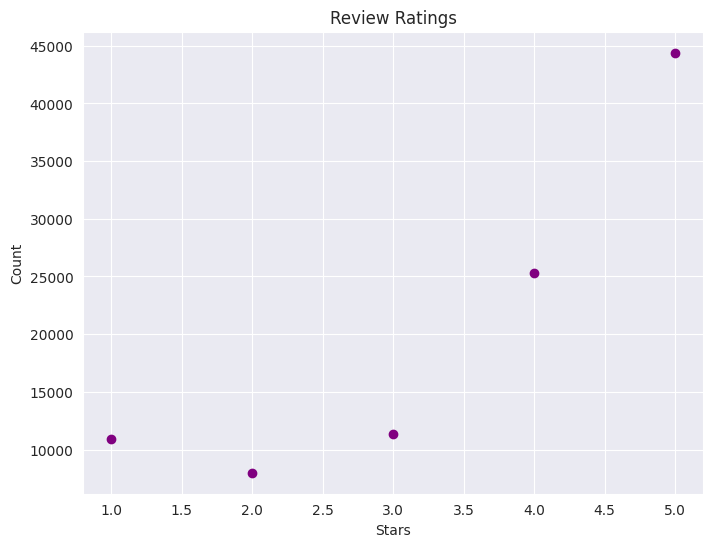

In [4]:
### Data Visualization
plt.figure(figsize=(8, 6))
plt.scatter(df['stars'].value_counts().sort_index().index, df['stars'].value_counts().sort_index(), color='purple')
plt.title('Review Ratings')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()

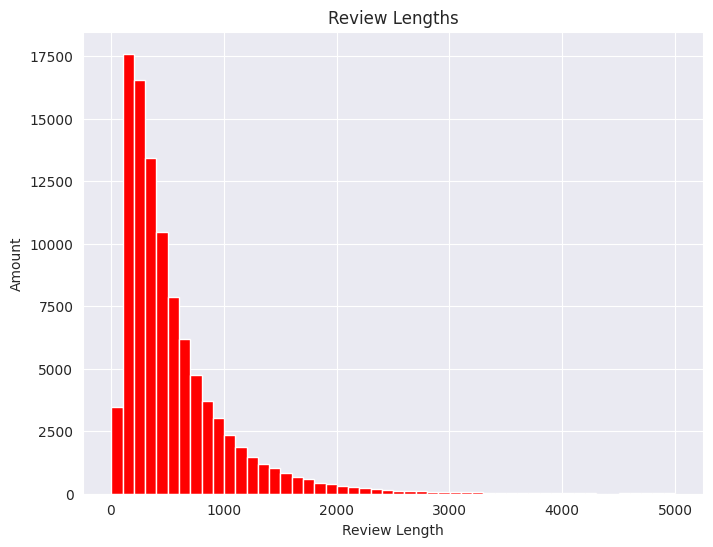

In [5]:
# Plot the distribution of review lengths
plt.figure(figsize=(8, 6))
df['review_length'] = df['text'].apply(len)
df['review_length'].hist(bins=50, color='red')
plt.title('Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Amount')
plt.show()

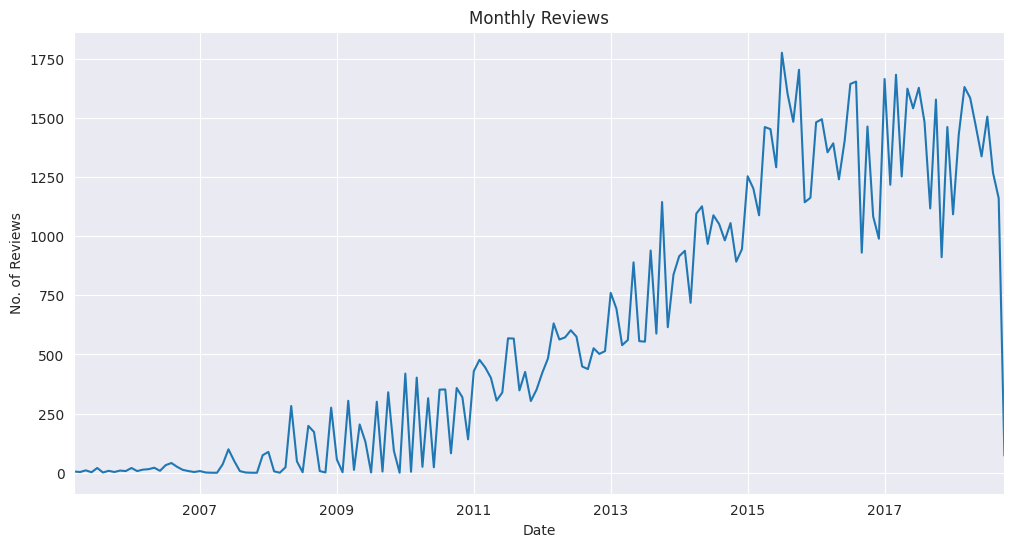

In [6]:
df['date'] = pd.to_datetime(df['date'])

# Plot the time distribution of reviews
plt.figure(figsize=(12, 6))
df.set_index('date').resample('M').size().plot()
plt.title('Monthly Reviews')
plt.xlabel('Date')
plt.ylabel('No. of Reviews')
plt.show()
matrix = df[['stars', 'useful', 'funny', 'cool', 'review_length']].corr()


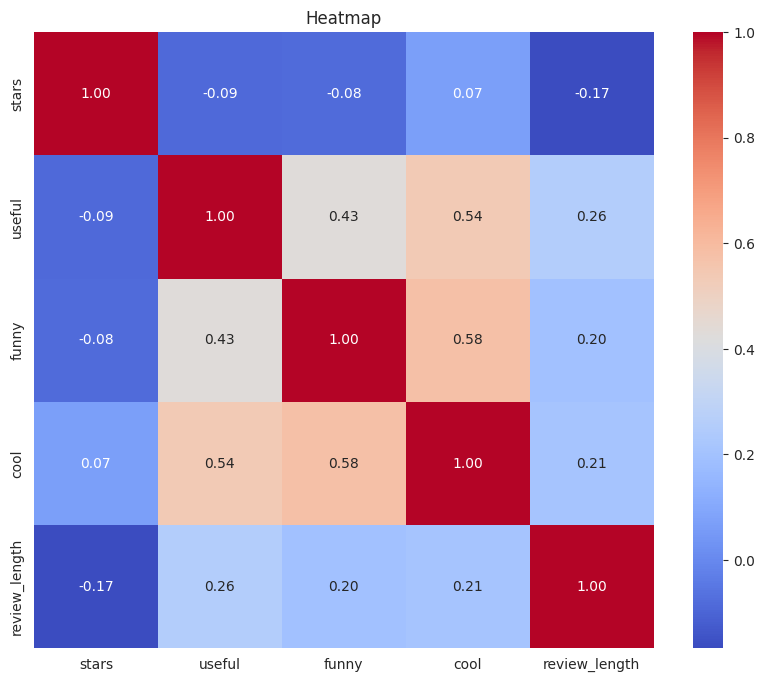

In [7]:
# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap')
plt.show()

### Prepairing sentiment Labales

In [8]:
def sentiment(stars):  #Ashken
    if 0 <= stars <= 2.5:
        return -1 #negative
    elif 2.6 <= stars <= 3.4:
        return 0 #normal
    elif 3.5 <= stars <= 5:
        return 1 #positive
    else:
        return 'undefined'

df['sentiment_label'] = df['stars'].apply(sentiment)
le = LabelEncoder()
df['encoded_sentiment'] = le.fit_transform(df['sentiment_label'])

# Extract labels
y = df['encoded_sentiment'].values
df.to_csv('preprocessed_data1.csv', index=False)

In [9]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_length,sentiment_label,encoded_sentiment
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,513,0,1
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,829,1,2
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,339,0,1
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,243,1,2
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,534,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,pAEbIxvr6ebx2bHc1XvguA,SMH5CeiLvKx61lKwtLZ_PA,lV0k3BnslFRkuWD_kbKd0Q,4,0,0,0,Came here for lunch with a group. They were bu...,2018-05-30 22:28:56,208,1,2
99996,xH1AoE-4nf2ECGQJRjO4_g,2clTdtp-BjphxLjN83CpUA,G0xz3kyRhRi6oZl7KfR0pA,1,1,0,0,The equipment is so old and so felty! I just u...,2015-04-05 23:31:52,205,-1,0
99997,GatIbXTz-WDru5emONUSIg,MRrN6DH3QGCFcDv5RENYVg,C4lZdhasjZVQyDlOiXY1sA,4,0,0,0,This is one of my favorite Mexican restaurants...,2016-06-04 00:59:15,234,1,2
99998,6NfkodAdhvI89xONXuBC3A,rnNQzeKJbvqVCsYsL10mkQ,dChRGpit9fM_kZK5pafNyA,2,0,0,0,Came here for brunch - had an omlette ($19 + t...,2018-06-11 12:45:08,258,-1,0


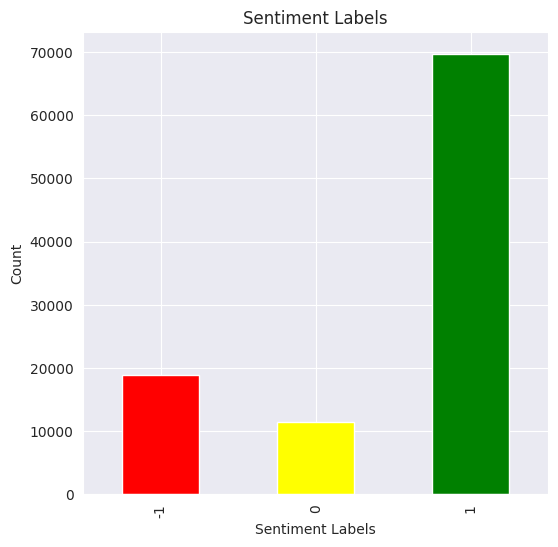

In [10]:
plt.figure(figsize=(6, 6))
df['sentiment_label'].value_counts().sort_index().plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Sentiment Labels')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.show()